In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import os
import pickle
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import copy
from abc import ABC, abstractmethod

from cubic_subproblem_solver import *

# Helper functions

In [2]:
def get_principal_vecs(X, new_dim):
    assert new_dim <= X.shape[1]
    sigma, V = torch.linalg.eigh(X.T @ X)
    princ_vecs = V[:,-new_dim:]
    return princ_vecs


def load_and_transform_mnist(new_dim):
    mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
    mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)
    
    X_train = mnist_trainset.data.reshape(-1,28*28) / 255.
    y_train = mnist_trainset.targets
    X_test = mnist_testset.data.reshape(-1,28*28) / 255.
    y_test = mnist_testset.targets
    
    princ_vecs = get_principal_vecs(X_train, new_dim)
    X_train = X_train @ princ_vecs
    X_test = X_test @ princ_vecs
    
    mnist_dataset = {
        "train_data": X_train,
        "train_targets": y_train,
        "test_data": X_test,
        "test_targets": y_test
    }
    
    return mnist_dataset


def transform_labels_to_binary(labels):
    return torch.tensor(list(map(lambda x: 0 if x<5 else 1, labels)))


class LogisticNet(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        return self.linear(x)


class MLP(nn.Module):
    
    def __init__(self, dims, activation):
        super().__init__()
        assert len(dims) >= 2
        self.activation = activation
        self.n_layers = len(dims) - 1
        self.layers = nn.ModuleList()
        for i in range(self.n_layers):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))
    
    def forward(self, x):
        for i in range(self.n_layers - 1):
            x = self.activation(self.layers[i](x))
        return self.layers[self.n_layers - 1](x)


# Abstract class Trainer

In [3]:
class Trainer(ABC):
    
    def __init__(self, model, dataset, criterion):
        
        self.model = model
        self.dataset = dataset
        self.criterion = criterion
        
        self.metrics = {}
        self.initialize_metrics()
        
        # calculate metrics for initial model state
        self.update_metrics(0.0)
    
    def initialize_metrics(self):
        self.metrics = {
            "train_loss": [],
            "test_loss": [],
            "train_acc": [],
            "test_acc": [],
            "grad_norm": [],
            "time": [],
            "iter": []
        }
    
    def evaluate(self, X, y):
        with torch.no_grad():
            preds = self.model(X)
            loss = self.criterion(preds, y)
            preds = torch.argmax(preds, axis=1)
            acc = torch.mean((preds == y).float())
        return loss.item(), acc.item()
    
    def calculate_grad_norm(self, X, y):
        preds = self.model(X)
        loss = self.criterion(preds, y)
        self.model.zero_grad()
        loss.backward()
        grad_norm = math.sqrt(sum([p.grad.pow(2).sum() for p in self.model.parameters()]))
        return grad_norm
    
    def update_metrics(self, training_time, grad_norm=None):
        iteration = 0 if len(self.metrics["iter"]) == 0 else self.metrics["iter"][-1] + 1
        tr_loss, tr_acc = self.evaluate(self.dataset["train_data"], self.dataset["train_targets"])
        tst_loss, tst_acc = self.evaluate(self.dataset["test_data"], self.dataset["test_targets"])
        if grad_norm is None:
            grad_norm = self.calculate_grad_norm(self.dataset["train_data"], self.dataset["train_targets"])
        
        self.metrics["time"].append(training_time)
        self.metrics["iter"].append(iteration)
        self.metrics["grad_norm"].append(grad_norm)
        self.metrics["train_loss"].append(tr_loss)
        self.metrics["test_loss"].append(tst_loss)
        self.metrics["train_acc"].append(tr_acc)
        self.metrics["test_acc"].append(tst_acc)
    
    def afterprocess_metrics(self, max_time):
        assert len(self.metrics["time"]) > 0
        if self.metrics["time"][-1] > max_time:
            for key in self.metrics.keys():
                self.metrics[key].pop()
    
    @abstractmethod
    def print_training_stats(metrics, iteration):
        pass
    
    @abstractmethod
    def perform_training_loop(self, max_iters, max_time, print_every):
        pass
    
    def train(self, max_iters=None, max_time=None, print_every=None, eval_every=None):
        # every time we want to print metrics, it must be evaluated
        assert (print_every == None) or (print_every % eval_every == 0)
        assert max_iters != None or max_time != None
        if max_iters == None:
            max_iters = float('inf')
        if max_time == None:
            max_time = float('inf')
        
        if print_every != None:
            self.__class__.print_training_stats(self.metrics, -1)
        
        self.perform_training_loop(max_iters, max_time, print_every, eval_every)

        self.afterprocess_metrics(max_time)
        return self.metrics.copy()

# GD with adaptive L as child class

In [4]:
class AdaptiveGDTrainer(Trainer):
    
    def __init__(self, model, dataset, criterion, L_0, L_min):
        
        self.L = L_0
        self.L_min = L_min
        super().__init__(model, dataset, criterion)
    
    def initialize_metrics(self):
        super().initialize_metrics()
        self.metrics["L"] = []
    
    def update_metrics(self, training_time, grad_norm=None):
        super().update_metrics(training_time, grad_norm)
        self.metrics["L"].append(self.L)
    
    def print_training_stats(metrics, iteration):
        print(f'{metrics["iter"][iteration]: 6,d}: train loss = {metrics["train_loss"][iteration]: .16f}, \
L = {metrics["L"][iteration]: .3f}, time = {metrics["time"][iteration]: .2f} sec')
    
    def calculate_loss(self, another_model, X, y):
        with torch.no_grad():
            preds = another_model(X)
            loss = self.criterion(preds, y)
        return loss.item()
    
    def set_params(self, another_model, new_params):
        for p, d in zip(another_model.parameters(), new_params):
            p.data = d
    
    def perform_training_loop(self, max_iters, max_time, print_every, eval_every):
        start_time = time.perf_counter()
        total_time = self.metrics["time"][-1]
        i = self.metrics["iter"][-1]
        while (i < max_iters and self.metrics["time"][-1] < max_time):
            
            outputs = self.model(self.dataset["train_data"])
            self.model.zero_grad()
            loss = self.criterion(outputs, self.dataset["train_targets"])
            loss.backward()
            grad_norm_squared = sum([p.grad.pow(2).sum().item() for p in self.model.parameters()])
            model_next = copy.deepcopy(self.model)
            new_params = [p.data - 1/self.L * p.grad for p in self.model.parameters()]
            self.set_params(model_next, new_params)
            while (self.calculate_loss(model_next, self.dataset["train_data"], self.dataset["train_targets"]) > 
                    loss.item() - 1/(2*self.L) * grad_norm_squared):
                self.L *= 2
                new_params = [p.data - 1/self.L * p.grad for p in self.model.parameters()]
                self.set_params(model_next, new_params)
            self.set_params(self.model, new_params)
            
            if (i+1) % eval_every == 0:
                total_time += time.perf_counter() - start_time
                self.update_metrics(total_time, math.sqrt(grad_norm_squared))
                if print_every != None and (i+1) % print_every == 0:
                    self.__class__.print_training_stats(self.metrics, -1)
                start_time = time.perf_counter()
            self.L = max(self.L / 2, self.L_min)
            i += 1
        

# Cubic Newton with adaptive M as child class

In [5]:
class AdaptiveCubicNewtonTrainer(Trainer):
    
    def __init__(self, model, dataset, criterion, M_0, M_min):
        
        self.M = M_0
        self.M_min = M_min
        super().__init__(model, dataset, criterion)
    
    def initialize_metrics(self):
        super().initialize_metrics()
        self.metrics["M"] = []
    
    def update_metrics(self, training_time, grad_norm=None):
        super().update_metrics(training_time, grad_norm)
        self.metrics["M"].append(self.M)
     
    def print_training_stats(metrics, iteration):
        print(f'{metrics["iter"][iteration]: 5,d}: train loss = {metrics["train_loss"][iteration]: .16f}, \
M = {metrics["M"][iteration]: .3f}, time = {metrics["time"][iteration]: .2f} sec')
    
    def calculate_loss(self, another_model, X, y):
        with torch.no_grad():
            preds = another_model(X)
            loss = self.criterion(preds, y)
        return loss.item()
    
    def calculate_gradient(self, X, y):
        preds = self.model(X)
        loss = self.criterion(preds, y)
        gradients = torch.autograd.grad(loss, self.model.parameters())
        grad = torch.cat([g.flatten() for g in gradients], dim=0)
        return grad
        
    def calculate_hessian(self, X, y):
        
        def calculate_loss(*params):
            assert len(params) % 2 == 0
            n_layers = len(params) // 2
            preds = X
            for i in range(n_layers):
                preds = preds @ params[2*i].T + params[2*i+1]
            return self.criterion(preds, y)

        params = tuple([p.data for p in self.model.parameters()])
        hessians = torch.autograd.functional.hessian(calculate_loss, params)
        
        hessians = list(hessians)
        n = len(hessians)
        for i in range(n):
            hessians[i] = list(hessians[i])

        params_numels = [p.data.numel() for p in self.model.parameters()]

        for i in range(n):
            for j in range(n):
                hessians[i][j] = hessians[i][j].reshape(params_numels[i], params_numels[j])
            hessians[i] = torch.cat(hessians[i], axis=1)

        hessians = torch.cat(hessians, axis=0)

        return hessians
    
    def quadratic_form(self, loss, grad, hess, M, h):
        return loss + torch.dot(grad,h) + 0.5 * torch.dot(hess @ h, h) + M/6 * torch.linalg.norm(h,2)**3
    
    def update_model_params(self, another_model, delta):
        params_numels = [p.data.numel() for p in another_model.parameters()]
        t = list(torch.split(delta, params_numels))
        for i, p in enumerate(another_model.parameters()):
            p.data += t[i].reshape(p.data.shape)
    
    def perform_training_loop(self, max_iters, max_time, print_every, eval_every):
        start_time = time.perf_counter()
        total_time = self.metrics["time"][-1]
        i = self.metrics["iter"][-1]
        while (i < max_iters and self.metrics["time"][-1] < max_time):
            
            loss = self.calculate_loss(self.model, self.dataset["train_data"], self.dataset["train_targets"])
            grad = self.calculate_gradient(self.dataset["train_data"], self.dataset["train_targets"])
            hess = self.calculate_hessian(self.dataset["train_data"], self.dataset["train_targets"])
            h = torch.tensor(cubic_subproblem_solver(grad.numpy(), hess.numpy(), self.M))
            model_next = copy.deepcopy(self.model)
            self.update_model_params(model_next, h)

            while (self.calculate_loss(model_next, self.dataset["train_data"], self.dataset["train_targets"]) > 
                self.quadratic_form(loss, grad, hess, self.M, h)):
                self.M *= 2
                h = torch.tensor(cubic_subproblem_solver(grad.numpy(), hess.numpy(), self.M))
                for p, p_next in zip(self.model.parameters(), model_next.parameters()):
                    p_next.data = p.data.clone()
                self.update_model_params(model_next, h)

            self.update_model_params(self.model, h)
            
            if (i+1) % eval_every == 0:
                total_time += time.perf_counter() - start_time
                grad_norm = grad.pow(2).sum().sqrt().item()
                self.update_metrics(total_time, grad_norm)
                if print_every != None and (i+1) % print_every == 0:
                    self.__class__.print_training_stats(self.metrics, -1)
                start_time = time.perf_counter()
            
            self.M = max(self.M / 2, self.M_min)
            i += 1


# SGD with decaying lr as 1/sqrt(t)

In [44]:
class SGDTrainer(Trainer):
    
    def __init__(self, model, dataset, criterion, initial_lr, batch_size):
        
        self.initial_lr = initial_lr
        self.lr = initial_lr
        self.batch_size = batch_size
        super().__init__(model, dataset, criterion)
    
    def print_training_stats(metrics, iteration):
        print(f'{metrics["iter"][iteration]: 6,d}: train loss = {metrics["train_loss"][iteration]: .16f}, \
time = {metrics["time"][iteration]: .2f} sec')
    
    def perform_training_loop(self, max_iters, max_time, print_every, eval_every):
        start_time = time.perf_counter()
        total_time = self.metrics["time"][-1]
        i = self.metrics["iter"][-1]
        batch_start = 0
        while (i < max_iters and self.metrics["time"][-1] < max_time):
            self.lr = self.initial_lr / math.sqrt(i+1)
            batch_end = batch_start + self.batch_size
            outputs = self.model(self.dataset["train_data"][batch_start:batch_end])
            self.model.zero_grad()
            loss = self.criterion(outputs, self.dataset["train_targets"][batch_start:batch_end])
            loss.backward()
            with torch.no_grad():
                for p in self.model.parameters():
                    p.data -= self.lr * p.grad
            
            if (i+1) % eval_every == 0:
                total_time += time.perf_counter() - start_time
                self.update_metrics(total_time)
                if print_every != None and (i+1) % print_every == 0:
                    self.__class__.print_training_stats(self.metrics, -1)
                start_time = time.perf_counter()
            
            batch_start = batch_end if (batch_end < self.dataset["train_data"].shape[0]) else 0
            i += 1


# Trainer with custom optimizer

In [19]:
class CustomTrainer(Trainer):
    
    def __init__(self, model, dataset, criterion, OptimizerClass, optimizer_params, batch_size):
        
        super().__init__(model, dataset, criterion)
        self.optimizer = OptimizerClass(self.model.parameters(), **optim_params)
        self.batch_size = batch_size
    
    def print_training_stats(metrics, iteration):
        print(f'{metrics["iter"][iteration]: 6,d}: train loss = {metrics["train_loss"][iteration]: .16f}, \
time = {metrics["time"][iteration]: .2f} sec')
    
    def perform_training_loop(self, max_iters, max_time, print_every, eval_every):
        start_time = time.perf_counter()
        total_time = self.metrics["time"][-1]
        i = self.metrics["iter"][-1]
        batch_start = 0
        while (i < max_iters and self.metrics["time"][-1] < max_time):
            batch_end = batch_start + self.batch_size
            outputs = self.model(self.dataset["train_data"][batch_start:batch_end])
            self.optimizer.zero_grad()
            loss = self.criterion(outputs, self.dataset["train_targets"][batch_start:batch_end])
            loss.backward()
            self.optimizer.step()
            
            if (i+1) % eval_every == 0:
                total_time += time.perf_counter() - start_time
                self.update_metrics(total_time)
                if print_every != None and (i+1) % print_every == 0:
                    self.__class__.print_training_stats(self.metrics, -1)
                start_time = time.perf_counter()
            
            batch_start = batch_end if (batch_end < self.dataset["train_data"].shape[0]) else 0
            i += 1


# Experiments

In [8]:
def dict_lists_to_ndarrays(metrics):
    for key, value in metrics.items():
        metrics[key] = np.array(value)
    return metrics

def print_training_stats(TrainerClass, metrics, print_every):
    if print_every != None:
        for i in range(0, len(metrics["iter"])):
            if metrics["iter"][i] % print_every == 0:
                TrainerClass.print_training_stats(metrics, i)

def train(TrainerClass, get_net_fn, get_dataset_fn, loss_function, results_file, max_iters,
          print_every, eval_every, retrain, **kwargs):
    try:
        if retrain:
            raise FileNotFoundError

        with open(os.path.join(PATH, results_file), "rb") as f:
            metrics = pickle.load(f)
        print("Training statistics was already calculated before:\n")
        print_training_stats(TrainerClass, metrics, print_every)
    except:
        print("Retraining model:\n")
        net = get_net_fn()
        dataset = get_dataset_fn()
        trainer = TrainerClass(net, dataset, loss_function, **kwargs)
        metrics = dict_lists_to_ndarrays(trainer.train(max_iters, print_every=print_every, eval_every=eval_every))
        with open(os.path.join(PATH, results_file), "wb") as f:
            pickle.dump(metrics, f)
    return metrics

### Logistic regression

In [9]:
PATH = os.path.join(os.getcwd(), "saved_calc\\logistic_regression")

if not os.path.isdir(PATH):
    os.makedirs(PATH)

In [10]:
new_dim = 20

net = LogisticNet(new_dim, 10)

loss_function = nn.CrossEntropyLoss()

MIN_TRAIN_LOSS = 0.4153611660003662 # for model = LogisticNet(20,10)
MIN_TEST_LOSS = 0.3710212409496307 # for model = LogisticNet(20,10)

def get_net():
    return copy.deepcopy(net)

def get_dataset():
    return load_and_transform_mnist(new_dim)

In [46]:
results_file = "SGD_metrics.pkl"
max_iters = 100
print_every = 10
eval_every = 1
retrain = False
# kwargs
init_lr = 1.0
b_size = 128

SGD_metrics = train(SGDTrainer, get_net, get_dataset, loss_function, results_file, max_iters,
          print_every, eval_every, retrain, initial_lr=init_lr, batch_size=b_size)

Training statistics was already calculated before:

     0: train loss =  2.8709685802459717, time =  0.00 sec
    10: train loss =  0.9453840255737305, time =  0.01 sec
    20: train loss =  0.7668405175209045, time =  0.01 sec
    30: train loss =  0.6937565207481384, time =  0.02 sec
    40: train loss =  0.6487137079238892, time =  0.02 sec
    50: train loss =  0.6307248473167419, time =  0.03 sec
    60: train loss =  0.6106147170066833, time =  0.03 sec
    70: train loss =  0.6045189499855042, time =  0.04 sec
    80: train loss =  0.5869753360748291, time =  0.05 sec
    90: train loss =  0.5767534971237183, time =  0.05 sec
   100: train loss =  0.5708099007606506, time =  0.06 sec


In [23]:
results_file = "SGD_const_lr_metrics.pkl"
max_iters = 100
print_every = 10
eval_every = 1
retrain = False
# kwargs
optim_class = torch.optim.SGD
optim_params = {'lr': 0.1}
b_size = 128

SGD_const_lr_metrics = train(CustomTrainer, get_net, get_dataset, loss_function, results_file, max_iters,
          print_every, eval_every, retrain, OptimizerClass=optim_class, optimizer_params=optim_params, 
                             batch_size=b_size)

Training statistics was already calculated before:

     0: train loss =  2.8709685802459717, time =  0.00 sec
    10: train loss =  1.8483208417892456, time =  0.01 sec
    20: train loss =  1.3808922767639160, time =  0.01 sec
    30: train loss =  1.1195056438446045, time =  0.02 sec
    40: train loss =  0.9729473590850830, time =  0.02 sec
    50: train loss =  0.8833190202713013, time =  0.03 sec
    60: train loss =  0.8165482282638550, time =  0.04 sec
    70: train loss =  0.7815045118331909, time =  0.04 sec
    80: train loss =  0.7352264523506165, time =  0.05 sec
    90: train loss =  0.7037043571472168, time =  0.05 sec
   100: train loss =  0.6813464760780334, time =  0.06 sec


In [13]:
results_file = "GD_metrics.pkl"
max_iters = 100
print_every = 10
eval_every = 1
retrain = False
# kwargs
Lipschitz_const = 1.0
Lipschitz_const_min = 0.001

GD_metrics = train(AdaptiveGDTrainer, get_net, get_dataset, loss_function, results_file, max_iters,
          print_every, eval_every, retrain, L_0=Lipschitz_const, L_min=Lipschitz_const_min)

Training statistics was already calculated before:

     0: train loss =  2.4906418323516846, L =  1.000, time =  0.00 sec
    10: train loss =  0.8740270733833313, L =  2.000, time =  0.35 sec
    20: train loss =  0.6331110596656799, L =  2.000, time =  0.71 sec
    30: train loss =  0.5610314011573792, L =  1.000, time =  1.04 sec
    40: train loss =  0.5224452614784241, L =  1.000, time =  1.39 sec
    50: train loss =  0.4971174597740173, L =  1.000, time =  1.78 sec
    60: train loss =  0.4787971675395966, L =  2.000, time =  2.15 sec
    70: train loss =  0.4666267633438110, L =  1.000, time =  2.48 sec
    80: train loss =  0.4584553241729736, L =  2.000, time =  2.84 sec
    90: train loss =  0.4518511295318604, L =  2.000, time =  3.21 sec
   100: train loss =  0.4459648430347443, L =  1.000, time =  3.54 sec


In [14]:
results_file = "CN_metrics.pkl"
max_iters = 10
print_every = 1
eval_every = 1
retrain = False
# kwargs
Lipschitz_const = 1.0
Lipschitz_const_min = 0.001

CN_metrics = train(AdaptiveCubicNewtonTrainer, get_net, get_dataset, loss_function, results_file, max_iters,
          print_every, eval_every, retrain, M_0=Lipschitz_const, M_min=Lipschitz_const_min)

Training statistics was already calculated before:

    0: train loss =  2.4906418323516846, M =  1.000, time =  0.00 sec
    1: train loss =  1.4419920444488525, M =  1.000, time =  4.43 sec
    2: train loss =  0.9549877047538757, M =  0.500, time =  8.91 sec
    3: train loss =  0.7109970450401306, M =  0.250, time =  13.41 sec
    4: train loss =  0.5774843096733093, M =  0.125, time =  18.12 sec
    5: train loss =  0.5018146634101868, M =  0.062, time =  24.09 sec
    6: train loss =  0.4588144123554230, M =  0.031, time =  29.53 sec
    7: train loss =  0.4349520206451416, M =  0.016, time =  35.33 sec
    8: train loss =  0.4225962162017822, M =  0.008, time =  40.35 sec
    9: train loss =  0.4172271490097046, M =  0.004, time =  45.84 sec
   10: train loss =  0.4156266748905182, M =  0.002, time =  51.32 sec


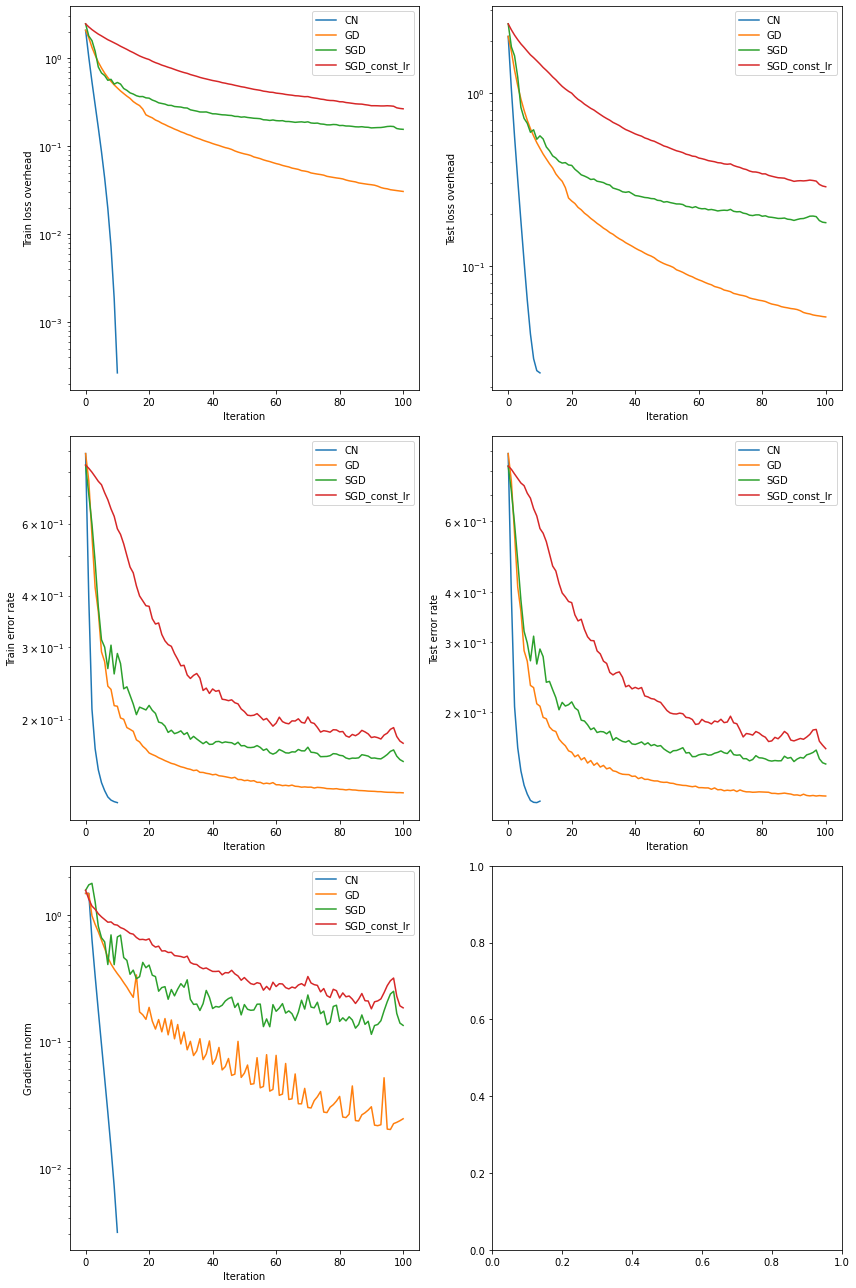

In [48]:
fig, ax = plt.subplots(3,2, figsize=(12,18))

ax[0,0].plot(CN_metrics["iter"], CN_metrics["train_loss"] - MIN_TRAIN_LOSS, label="CN")
ax[0,0].plot(GD_metrics["iter"], GD_metrics["train_loss"] - MIN_TRAIN_LOSS, label="GD")
ax[0,0].plot(SGD_metrics["iter"], SGD_metrics["train_loss"] - MIN_TRAIN_LOSS, label="SGD")
ax[0,0].plot(SGD_const_lr_metrics["iter"], SGD_const_lr_metrics["train_loss"] - MIN_TRAIN_LOSS, label="SGD_const_lr")
ax[0,0].set_xlabel("Iteration")
ax[0,0].set_ylabel("Train loss overhead")
ax[0,0].set_yscale('log')
ax[0,0].legend()

ax[0,1].plot(CN_metrics["iter"], CN_metrics["test_loss"] - MIN_TEST_LOSS, label="CN")
ax[0,1].plot(GD_metrics["iter"], GD_metrics["test_loss"] - MIN_TEST_LOSS, label="GD")
ax[0,1].plot(SGD_metrics["iter"], SGD_metrics["test_loss"] - MIN_TEST_LOSS, label="SGD")
ax[0,1].plot(SGD_const_lr_metrics["iter"], SGD_const_lr_metrics["test_loss"] - MIN_TEST_LOSS, label="SGD_const_lr")
ax[0,1].set_xlabel("Iteration")
ax[0,1].set_ylabel("Test loss overhead")
ax[0,1].set_yscale('log')
ax[0,1].legend()

ax[1,0].plot(CN_metrics["iter"], 1 - CN_metrics["train_acc"], label="CN")
ax[1,0].plot(GD_metrics["iter"], 1 - GD_metrics["train_acc"], label="GD")
ax[1,0].plot(SGD_metrics["iter"], 1 - SGD_metrics["train_acc"], label="SGD")
ax[1,0].plot(SGD_const_lr_metrics["iter"], 1 - SGD_const_lr_metrics["train_acc"], label="SGD_const_lr")
ax[1,0].set_xlabel("Iteration")
ax[1,0].set_ylabel("Train error rate")
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].plot(CN_metrics["iter"], 1 - CN_metrics["test_acc"], label="CN")
ax[1,1].plot(GD_metrics["iter"], 1 - GD_metrics["test_acc"], label="GD")
ax[1,1].plot(SGD_metrics["iter"], 1 - SGD_metrics["test_acc"], label="SGD")
ax[1,1].plot(SGD_const_lr_metrics["iter"], 1 - SGD_const_lr_metrics["test_acc"], label="SGD_const_lr")
ax[1,1].set_xlabel("Iteration")
ax[1,1].set_ylabel("Test error rate")
ax[1,1].set_yscale('log')
ax[1,1].legend()

ax[2,0].plot(CN_metrics["iter"], CN_metrics["grad_norm"], label="CN")
ax[2,0].plot(GD_metrics["iter"], GD_metrics["grad_norm"], label="GD")
ax[2,0].plot(SGD_metrics["iter"], SGD_metrics["grad_norm"], label="SGD")
ax[2,0].plot(SGD_const_lr_metrics["iter"], SGD_const_lr_metrics["grad_norm"], label="SGD_const_lr")
ax[2,0].set_xlabel("Iteration")
ax[2,0].set_ylabel("Gradient norm")
ax[2,0].set_yscale('log')
ax[2,0].legend()

fig.tight_layout()
plt.show()

### 1-hidden layer Neural Network

In [26]:
PATH = os.path.join(os.getcwd(), "saved_calc\\two_layers_NN")

if not os.path.isdir(PATH):
    os.makedirs(PATH)

In [27]:
new_dim = 10 # new feature dimension

loss_function = nn.CrossEntropyLoss()
# initialization better be the same for all methods
net = MLP([new_dim, 10, 2], torch.relu)

In [44]:
net_SGD_decaying_lr = copy.deepcopy(net)
initial_lr = 0.5
max_iters = 2000
b_size = 128 # batch_size

results_file = "SGD_decaying_lr_metrics.pkl"
print_every = 10
eval_every = 1

retrain = True # if True, retrain the model even if the metrics were already stored in memory

try:
    if retrain:
        raise FileNotFoundError
    
    with open(os.path.join(PATH, results_file), "rb") as f:
        SGD_decaying_lr_metrics = pickle.load(f)
    print("Training statistics was already calculated before:\n")
    print_training_stats(SGDTrainerDecayingLR, SGD_decaying_lr_metrics, print_every)
except:
    print("Retraining model:\n")
    
    # loading the dataset for each method to make sure it the same for all methods
    # even if the dataset is corrupted during one of the methods training
    # for example, SGD may use reshuffling
    mnist_dataset = load_and_transform_mnist(new_dim)
    # tranforming labels to binary to reduce model size
    mnist_dataset["train_targets"] = transform_labels_to_binary(mnist_dataset["train_targets"])
    mnist_dataset["test_targets"] = transform_labels_to_binary(mnist_dataset["test_targets"])
    
    SGD_decaying_lr_trainer = SGDTrainerDecayingLR(net_SGD_decaying_lr, mnist_dataset, loss_function, 
                                                   initial_lr, b_size)
    SGD_decaying_lr_metrics = dict_lists_to_ndarrays(SGD_decaying_lr_trainer.train(max_iters, 
                                                                                   print_every=print_every, 
                                                                                   eval_every=eval_every))
    
    with open(os.path.join(PATH, results_file), "wb") as f:
        pickle.dump(SGD_decaying_lr_metrics, f)

Retraining model:

     0: train loss =  0.7196127772331238, time =  0.00 sec
    10: train loss =  0.6406108736991882, time =  0.01 sec
    20: train loss =  0.6124932169914246, time =  0.01 sec
    30: train loss =  0.5932343602180481, time =  0.02 sec
    40: train loss =  0.5791818499565125, time =  0.03 sec
    50: train loss =  0.5651531219482422, time =  0.04 sec
    60: train loss =  0.5523030161857605, time =  0.04 sec
    70: train loss =  0.5468263626098633, time =  0.05 sec
    80: train loss =  0.5328297615051270, time =  0.06 sec
    90: train loss =  0.5242109298706055, time =  0.07 sec
   100: train loss =  0.5159410834312439, time =  0.08 sec
   110: train loss =  0.5111405849456787, time =  0.08 sec
   120: train loss =  0.5002966523170471, time =  0.09 sec
   130: train loss =  0.4914738833904266, time =  0.10 sec
   140: train loss =  0.4843370020389557, time =  0.10 sec
   150: train loss =  0.4766504168510437, time =  0.11 sec
   160: train loss =  0.4685915410518

 1,390: train loss =  0.3237369358539581, time =  1.24 sec
 1,400: train loss =  0.3235039412975311, time =  1.25 sec
 1,410: train loss =  0.3233501613140106, time =  1.26 sec
 1,420: train loss =  0.3229627311229706, time =  1.27 sec
 1,430: train loss =  0.3228635787963867, time =  1.28 sec
 1,440: train loss =  0.3232823610305786, time =  1.30 sec
 1,450: train loss =  0.3219111561775208, time =  1.32 sec
 1,460: train loss =  0.3225282132625580, time =  1.34 sec
 1,470: train loss =  0.3215649127960205, time =  1.35 sec
 1,480: train loss =  0.3243991434574127, time =  1.36 sec
 1,490: train loss =  0.3207523822784424, time =  1.37 sec
 1,500: train loss =  0.3203299045562744, time =  1.39 sec
 1,510: train loss =  0.3204487562179565, time =  1.40 sec
 1,520: train loss =  0.3200165629386902, time =  1.41 sec
 1,530: train loss =  0.3197336494922638, time =  1.42 sec
 1,540: train loss =  0.3194219470024109, time =  1.43 sec
 1,550: train loss =  0.3198818862438202, time =  1.45 s

In [45]:
net_SGD = copy.deepcopy(net)
optim = torch.optim.SGD(net_SGD.parameters(), lr=0.1) # what is the right scheme for lr? ~1/sqrt(t)?
max_iters = 2000
b_size = 128 # batch_size

results_file = "SGD_metrics.pkl"
print_every = 10
eval_every = 1

retrain = True # if True, retrain the model even if the metrics were already stored in memory

try:
    if retrain:
        raise FileNotFoundError
    
    with open(os.path.join(PATH, results_file), "rb") as f:
        SGD_metrics = pickle.load(f)
    print("Training statistics was already calculated before:\n")
    print_training_stats(SGDTrainer, SGD_metrics, print_every)
except:
    print("Retraining model:\n")
    
    mnist_dataset = load_and_transform_mnist(new_dim)
    # tranforming labels to binary to reduce model size
    mnist_dataset["train_targets"] = transform_labels_to_binary(mnist_dataset["train_targets"])
    mnist_dataset["test_targets"] = transform_labels_to_binary(mnist_dataset["test_targets"])
    SGD_trainer = SGDTrainer(net_SGD, mnist_dataset, loss_function, optim, b_size)
    SGD_metrics = dict_lists_to_ndarrays(SGD_trainer.train(max_iters, print_every=print_every,
                                                           eval_every=eval_every))
    
    with open(os.path.join(PATH, results_file), "wb") as f:
        pickle.dump(SGD_metrics, f)

Retraining model:

     0: train loss =  0.7196127772331238, time =  0.00 sec
    10: train loss =  0.6814559698104858, time =  0.01 sec
    20: train loss =  0.6578232645988464, time =  0.02 sec
    30: train loss =  0.6348863840103149, time =  0.03 sec
    40: train loss =  0.6166829466819763, time =  0.04 sec
    50: train loss =  0.5902650952339172, time =  0.06 sec
    60: train loss =  0.5709162354469299, time =  0.07 sec
    70: train loss =  0.5654570460319519, time =  0.09 sec
    80: train loss =  0.5372778773307800, time =  0.10 sec
    90: train loss =  0.5194505453109741, time =  0.12 sec
   100: train loss =  0.5030781626701355, time =  0.13 sec
   110: train loss =  0.4959277808666229, time =  0.15 sec
   120: train loss =  0.4744805991649628, time =  0.17 sec
   130: train loss =  0.4557443559169769, time =  0.18 sec
   140: train loss =  0.4429392814636230, time =  0.19 sec
   150: train loss =  0.4310368597507477, time =  0.21 sec
   160: train loss =  0.4318969547748

 1,390: train loss =  0.2737617492675781, time =  1.48 sec
 1,400: train loss =  0.2772602438926697, time =  1.49 sec
 1,410: train loss =  0.2798125445842743, time =  1.50 sec
 1,420: train loss =  0.2781210243701935, time =  1.50 sec
 1,430: train loss =  0.2880153954029083, time =  1.51 sec
 1,440: train loss =  0.2777596712112427, time =  1.52 sec
 1,450: train loss =  0.2767972350120544, time =  1.52 sec
 1,460: train loss =  0.2988559305667877, time =  1.53 sec
 1,470: train loss =  0.2847659289836884, time =  1.54 sec
 1,480: train loss =  0.2893179953098297, time =  1.54 sec
 1,490: train loss =  0.3034414350986481, time =  1.55 sec
 1,500: train loss =  0.2708277702331543, time =  1.56 sec
 1,510: train loss =  0.2762309014797211, time =  1.56 sec
 1,520: train loss =  0.2828999161720276, time =  1.57 sec
 1,530: train loss =  0.2817328870296478, time =  1.58 sec
 1,540: train loss =  0.2781359553337097, time =  1.59 sec
 1,550: train loss =  0.2733660340309143, time =  1.59 s

In [32]:
net_GD = copy.deepcopy(net)
Lipschitz_const = 1.0
Lipschitz_const_min = 0.001
max_iters = 100

results_file = "GD_metrics.pkl"
print_every = 10
eval_every=1

retrain = False

try:
    if retrain:
        raise FileNotFoundError
    
    with open(os.path.join(PATH, results_file), "rb") as f:
        GD_metrics = pickle.load(f)
    print("Training statistics was already calculated before:\n")
    print_training_stats(AdaptiveGDTrainer, GD_metrics, print_every)
except:
    print("Retraining model:\n")
    
    mnist_dataset = load_and_transform_mnist(new_dim)
    # tranforming labels to binary to reduce model size
    mnist_dataset["train_targets"] = transform_labels_to_binary(mnist_dataset["train_targets"])
    mnist_dataset["test_targets"] = transform_labels_to_binary(mnist_dataset["test_targets"])

    GD_trainer = AdaptiveGDTrainer(net_GD, mnist_dataset, loss_function, Lipschitz_const, Lipschitz_const_min)
    GD_metrics = dict_lists_to_ndarrays(GD_trainer.train(max_iters, print_every=print_every,
                                                         eval_every=eval_every))
    
    with open(os.path.join(PATH, results_file), "wb") as f:
        pickle.dump(GD_metrics, f)

Training statistics was already calculated before:

     0: train loss =  0.7196127772331238, L =  1.000, time =  0.00 sec
    10: train loss =  0.5258226990699768, L =  2.000, time =  0.24 sec
    20: train loss =  0.4549674391746521, L =  2.000, time =  0.47 sec
    30: train loss =  0.4110554158687592, L =  8.000, time =  0.72 sec
    40: train loss =  0.3910982310771942, L =  16.000, time =  0.98 sec
    50: train loss =  0.3784167766571045, L =  8.000, time =  1.19 sec
    60: train loss =  0.3691538870334625, L =  8.000, time =  1.43 sec
    70: train loss =  0.3608113825321198, L =  16.000, time =  1.74 sec
    80: train loss =  0.3546822369098663, L =  8.000, time =  1.98 sec
    90: train loss =  0.3481968343257904, L =  8.000, time =  2.20 sec
   100: train loss =  0.3437428772449493, L =  8.000, time =  2.43 sec


In [34]:
net_CN = copy.deepcopy(net)
Lipschitz_const = 1.0
Lipschitz_const_min = 0.001
max_iters = 15

results_file = "CN_metrics.pkl"
print_every = 1
eval_every=1

retrain = False

try:
    if retrain:
        raise FileNotFoundError
    
    with open(os.path.join(PATH, results_file), "rb") as f:
        CN_metrics = pickle.load(f)
    print("Training statistics was already calculated before:\n")
    print_training_stats(AdaptiveCubicNewtonTrainer, CN_metrics, print_every)
except:
    print("Retraining model:\n")
    
    mnist_dataset = load_and_transform_mnist(new_dim)
    # tranforming labels to binary to reduce model size
    mnist_dataset["train_targets"] = transform_labels_to_binary(mnist_dataset["train_targets"])
    mnist_dataset["test_targets"] = transform_labels_to_binary(mnist_dataset["test_targets"])

    CN_trainer = AdaptiveCubicNewtonTrainer(net_CN, mnist_dataset, loss_function, Lipschitz_const, Lipschitz_const_min)
    CN_metrics = dict_lists_to_ndarrays(CN_trainer.train(max_iters, print_every=print_every,
                                                         eval_every=eval_every))
    
    with open(os.path.join(PATH, results_file), "wb") as f:
        pickle.dump(CN_metrics, f)

Training statistics was already calculated before:

    0: train loss =  0.7196127772331238, M =  1.000, time =  0.00 sec
    1: train loss =  0.6917847394943237, M =  32.000, time =  1.39 sec
    2: train loss =  0.6771264076232910, M =  32.000, time =  2.70 sec
    3: train loss =  0.6536399722099304, M =  16.000, time =  3.90 sec
    4: train loss =  0.6399027705192566, M =  32.000, time =  5.19 sec
    5: train loss =  0.6217155456542969, M =  16.000, time =  6.44 sec
    6: train loss =  0.6089941263198853, M =  32.000, time =  7.75 sec
    7: train loss =  0.5989387631416321, M =  64.000, time =  9.23 sec
    8: train loss =  0.5845225453376770, M =  32.000, time =  10.71 sec
    9: train loss =  0.5694721341133118, M =  16.000, time =  12.13 sec
   10: train loss =  0.5601684451103210, M =  128.000, time =  13.66 sec
   11: train loss =  0.5515687465667725, M =  64.000, time =  15.16 sec
   12: train loss =  0.5402624607086182, M =  32.000, time =  16.68 sec
   13: train loss = 

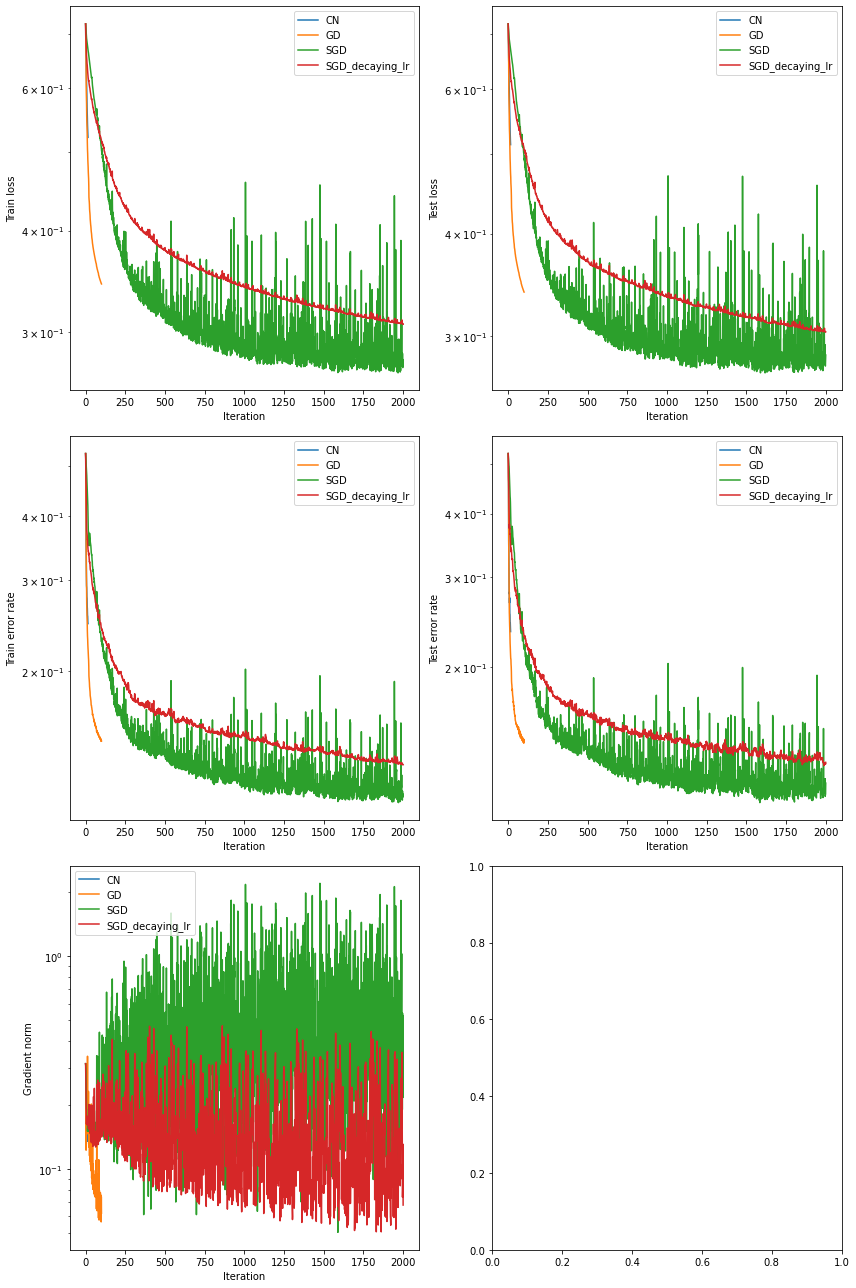

In [46]:
fig, ax = plt.subplots(3,2, figsize=(12,18))

ax[0,0].plot(CN_metrics["iter"], CN_metrics["train_loss"], label="CN")
ax[0,0].plot(GD_metrics["iter"], GD_metrics["train_loss"], label="GD")
ax[0,0].plot(SGD_metrics["iter"], SGD_metrics["train_loss"], label="SGD")
ax[0,0].plot(SGD_decaying_lr_metrics["iter"], SGD_decaying_lr_metrics["train_loss"], label="SGD_decaying_lr")
ax[0,0].set_xlabel("Iteration")
ax[0,0].set_ylabel("Train loss")
ax[0,0].set_yscale('log')
ax[0,0].legend()

ax[0,1].plot(CN_metrics["iter"], CN_metrics["test_loss"], label="CN")
ax[0,1].plot(GD_metrics["iter"], GD_metrics["test_loss"], label="GD")
ax[0,1].plot(SGD_metrics["iter"], SGD_metrics["test_loss"], label="SGD")
ax[0,1].plot(SGD_decaying_lr_metrics["iter"], SGD_decaying_lr_metrics["test_loss"], label="SGD_decaying_lr")
ax[0,1].set_xlabel("Iteration")
ax[0,1].set_ylabel("Test loss")
ax[0,1].set_yscale('log')
ax[0,1].legend()

ax[1,0].plot(CN_metrics["iter"], 1 - CN_metrics["train_acc"], label="CN")
ax[1,0].plot(GD_metrics["iter"], 1 - GD_metrics["train_acc"], label="GD")
ax[1,0].plot(SGD_metrics["iter"], 1 - SGD_metrics["train_acc"], label="SGD")
ax[1,0].plot(SGD_decaying_lr_metrics["iter"], 1 - SGD_decaying_lr_metrics["train_acc"], label="SGD_decaying_lr")
ax[1,0].set_xlabel("Iteration")
ax[1,0].set_ylabel("Train error rate")
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].plot(CN_metrics["iter"], 1 - CN_metrics["test_acc"], label="CN")
ax[1,1].plot(GD_metrics["iter"], 1 - GD_metrics["test_acc"], label="GD")
ax[1,1].plot(SGD_metrics["iter"], 1 - SGD_metrics["test_acc"], label="SGD")
ax[1,1].plot(SGD_decaying_lr_metrics["iter"], 1 - SGD_decaying_lr_metrics["test_acc"], label="SGD_decaying_lr")
ax[1,1].set_xlabel("Iteration")
ax[1,1].set_ylabel("Test error rate")
ax[1,1].set_yscale('log')
ax[1,1].legend()

ax[2,0].plot(CN_metrics["iter"], CN_metrics["grad_norm"], label="CN")
ax[2,0].plot(GD_metrics["iter"], GD_metrics["grad_norm"], label="GD")
ax[2,0].plot(SGD_metrics["iter"], SGD_metrics["grad_norm"], label="SGD")
ax[2,0].plot(SGD_decaying_lr_metrics["iter"], SGD_decaying_lr_metrics["grad_norm"], label="SGD_decaying_lr")
ax[2,0].set_xlabel("Iteration")
ax[2,0].set_ylabel("Gradient norm")
ax[2,0].set_yscale('log')
ax[2,0].legend()

fig.tight_layout()
plt.show()

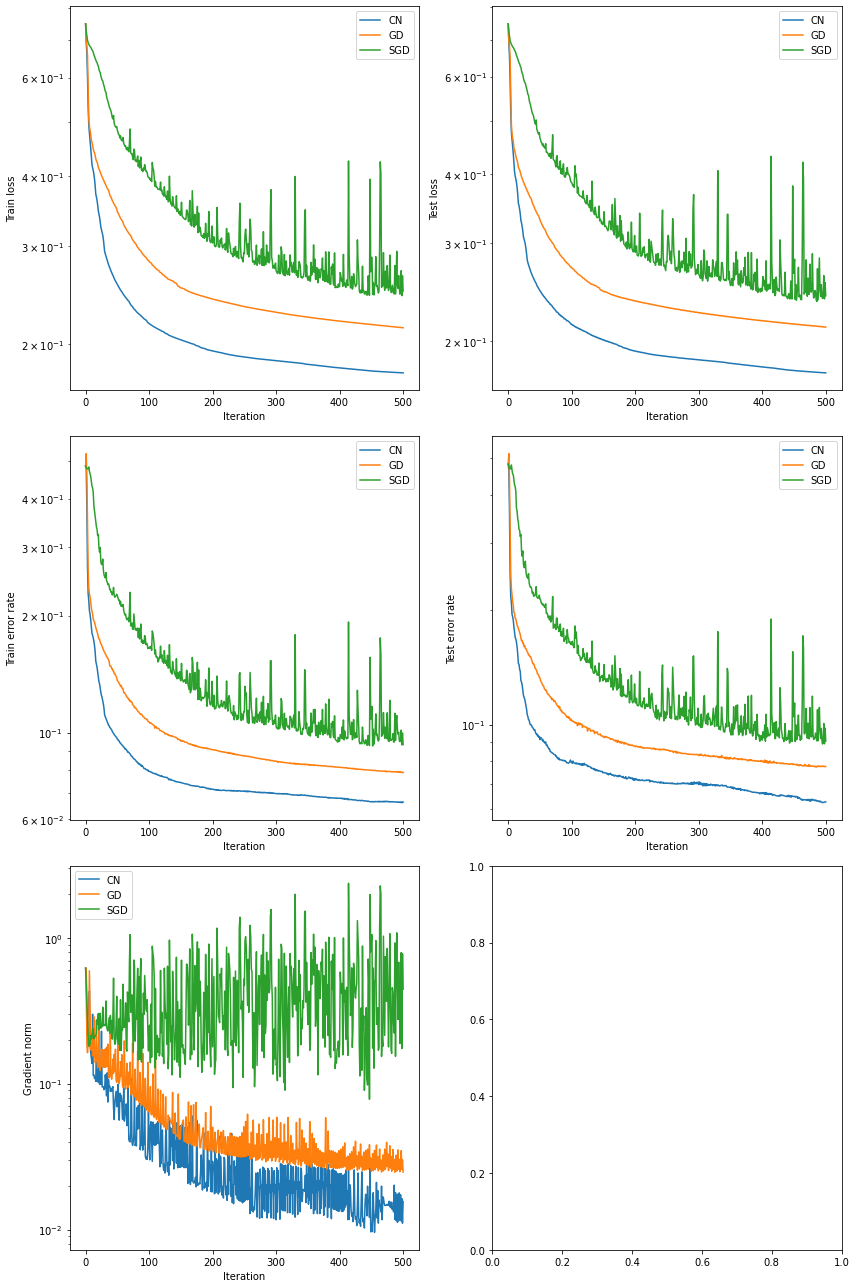

In [38]:
fig, ax = plt.subplots(3,2, figsize=(12,18))

ax[0,0].plot(CN_metrics["iter"], CN_metrics["train_loss"], label="CN")
ax[0,0].plot(GD_metrics["iter"], GD_metrics["train_loss"], label="GD")
ax[0,0].plot(SGD_metrics["iter"], SGD_metrics["train_loss"], label="SGD")
ax[0,0].set_xlabel("Iteration")
ax[0,0].set_ylabel("Train loss")
ax[0,0].set_yscale('log')
ax[0,0].legend()

ax[0,1].plot(CN_metrics["iter"], CN_metrics["test_loss"], label="CN")
ax[0,1].plot(GD_metrics["iter"], GD_metrics["test_loss"], label="GD")
ax[0,1].plot(SGD_metrics["iter"], SGD_metrics["test_loss"], label="SGD")
ax[0,1].set_xlabel("Iteration")
ax[0,1].set_ylabel("Test loss")
ax[0,1].set_yscale('log')
ax[0,1].legend()

ax[1,0].plot(CN_metrics["iter"], 1 - CN_metrics["train_acc"], label="CN")
ax[1,0].plot(GD_metrics["iter"], 1 - GD_metrics["train_acc"], label="GD")
ax[1,0].plot(SGD_metrics["iter"], 1 - SGD_metrics["train_acc"], label="SGD")
ax[1,0].set_xlabel("Iteration")
ax[1,0].set_ylabel("Train error rate")
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].plot(CN_metrics["iter"], 1 - CN_metrics["test_acc"], label="CN")
ax[1,1].plot(GD_metrics["iter"], 1 - GD_metrics["test_acc"], label="GD")
ax[1,1].plot(SGD_metrics["iter"], 1 - SGD_metrics["test_acc"], label="SGD")
ax[1,1].set_xlabel("Iteration")
ax[1,1].set_ylabel("Test error rate")
ax[1,1].set_yscale('log')
ax[1,1].legend()

ax[2,0].plot(CN_metrics["iter"], CN_metrics["grad_norm"], label="CN")
ax[2,0].plot(GD_metrics["iter"], GD_metrics["grad_norm"], label="GD")
ax[2,0].plot(SGD_metrics["iter"], SGD_metrics["grad_norm"], label="SGD")
ax[2,0].set_xlabel("Iteration")
ax[2,0].set_ylabel("Gradient norm")
ax[2,0].set_yscale('log')
ax[2,0].legend()

fig.tight_layout()
plt.show()

<AxesSubplot:>

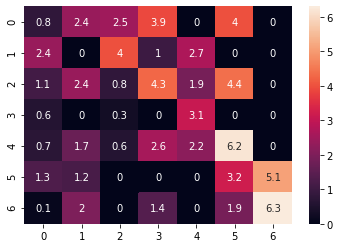

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])

# plt.imshow(harvest)
sns.heatmap(harvest, annot=True)